### all imports

In [1]:
import numpy as np
import os
from sigmf import SigMFFile, sigmffile
from matplotlib import pyplot as plt
import cv2
import imghdr
import tensorflow as tf

### Function before creating Images

Add Noice

In [2]:
def add_noise(samples):

    '''generating gaussian noise and adds to samples'''
    power=10**(-14/10)
    #     here we will keep noise power less than -13db

    size=samples.shape[0]
    
    noise=(np.random.randn(size)+1j*np.random.randn(size)/np.sqrt(2))*power
    
    samples=samples+noise
#     print(noise.imag.mean(),noise.real.mean())
#     print(noise.var())
#     plt.plot(noise.real,'.-')
#     plt.plot(noise.imag,'.-')
#     plt.show()
#     print(samples)
    return samples


plot and save

In [3]:
def plot_and_save(samples,imp_no):
    '''
    - takes as input a numpy array of complex numbers and impairment number
    
    - makes a folder with name of impairment number, plots 128 samples from numpy array, saves them, repeats till all samples are covered
    '''
    
    #  plot and save graphs

    if not os.path.exists('C:/Users/Lenovo/Desktop/oracle dataset/first_convert_to_images_then_train/graphs_of_{}'.format(imp_no)):
        os.makedirs('C:/Users/Lenovo/Desktop/oracle dataset/first_convert_to_images_then_train/graphs_of_{}'.format(imp_no))
    os.chdir('C:/Users/Lenovo/Desktop/oracle dataset/first_convert_to_images_then_train/graphs_of_{}'.format(imp_no))

# "C:/Users/Lenovo/Desktop/oracle dataset/first_convert_to_images_then_train"

    lower_range=0
    upper_range=lower_range+128

    file_name=''
    images_saved=0
    while upper_range<all_samples[0].shape[0]:

        fig=plt.figure()

        plt.plot(samples[lower_range:upper_range].real,samples[lower_range:upper_range].imag,'.')
        
        file_name='{}_to_{}'.format(lower_range,(upper_range-1))
        
        fig.savefig(file_name)
        
        plt.close(fig)
        images_saved+=1
        
#         plt.title('{}_{}'.format(lower_range,upper_range))
#         plt.show()

        lower_range=upper_range
        upper_range+=128
        if(images_saved==1000):
            break

load samples in numpy array

In [3]:
sample_no=[1,2,3,4,5,7,9,13,14,15,17,18,19,25,26,32]

all_samples=np.array

temp=[]
for i in sample_no:
    
    file_name="Demod_WiFi_cable_X310_3123D76_IQ#{}_run1.sigmf-data".format(i)
    signal=sigmffile.fromfile(file_name)
    temp.append(np.array(signal.read_samples().view(np.complex128)))

all_samples=np.array(temp,dtype='object')

In [19]:
# save samples
# for i in range(0,16):
#     samples_with_noise=add_noise(all_samples[i])
#     plot_and_save(samples_with_noise,sample_no[i])

### Loading Images

In [2]:
data_dir='data_folders'
# img=cv2.imread(os.path.join('data_folders','graphs_of_1','0_to_127.png'))

In [10]:
# os.listdir(data_dir)

In [11]:
# type(img)
# img
# img.shape

# plt.imshow(img)
# plt.show()

load saved images

In [3]:
# data=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(480,640))
# data=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(480,480))
data=tf.keras.utils.image_dataset_from_directory(data_dir)
# data=tf.keras.utils.image_dataset_from_directory(data_dir,batch_size=8,image_size=(480,640))

Found 16000 files belonging to 16 classes.


iterator

In [4]:
data_iterator=data.as_numpy_iterator()

selecting a batch using iterator

In [5]:
#  get another batch from the iterator
batch=data_iterator.next()
# batch[1].shape # class number
# batch[0].shape # shape of data

In [8]:
batch[0][0].shape
# plt.imshow(batch[0][0])
# plt.show()

(256, 256, 3)

In [9]:
batch[1]

array([12, 11,  6, 12, 11,  1,  7,  4,  6,  4, 10, 15, 13, 12,  1,  3, 13,
        7,  1,  5,  2,  0,  8,  8,  4,  6, 10, 10, 13, 12,  9, 11])

checking loaded images in a batch

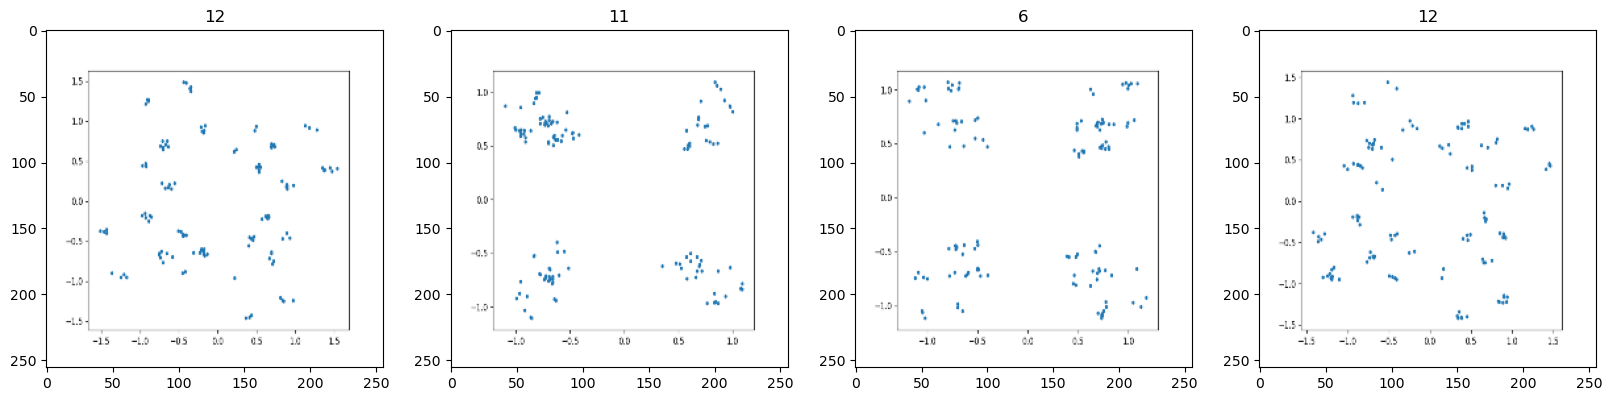

In [10]:
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Normalizing data

normalizing data by dividing by 255

In [11]:
# scaled=batch[0]/255
scaled_data=data.map(lambda x,y: (x/255,y))

scaled iterator

In [12]:
scaled_iterator=scaled_data.as_numpy_iterator()

#### making batch of scaled data

In [13]:
scaled_batch=scaled_iterator.next()

In [14]:
scaled_batch[0].shape

(32, 256, 256, 3)

In [15]:
print(scaled_batch[0].max(),',',scaled_batch[0].min())

1.0 , 0.008700981


#### *checking images of scaled_batch*

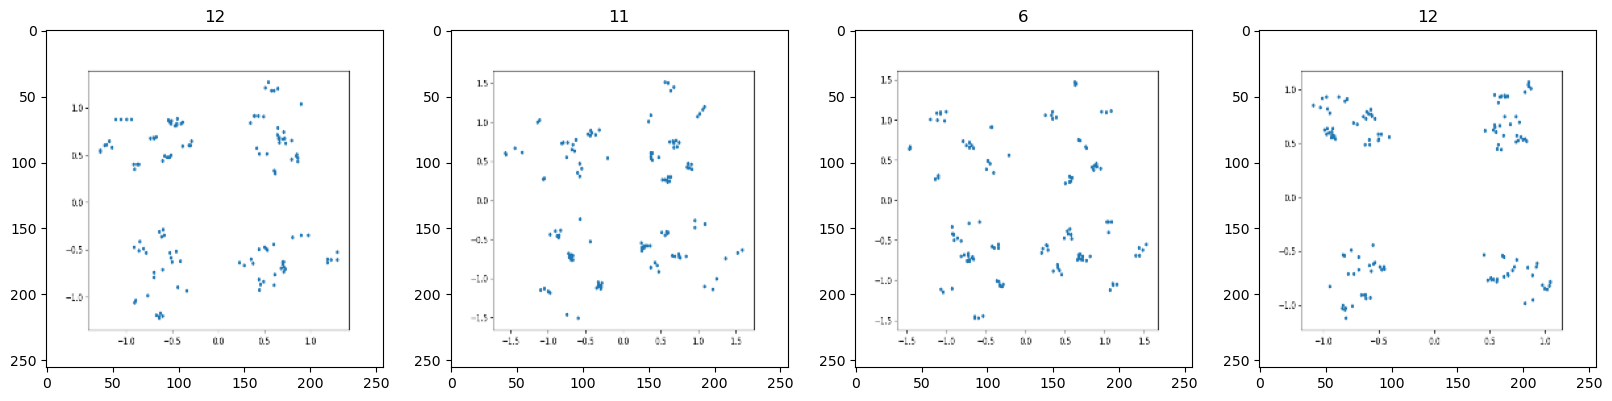

In [16]:
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img) # here img is not a integer
    ax[idx].title.set_text(batch[1][idx])

### Splitting data

here length of data is 500 because:
- batch size is 32
- and total images are 16000 (1000 images in 16 folders)
- hence: 16000/32=500

In [17]:
print('total batches : ',len(data))

total batches :  500


setting size for train, val, test:

In [18]:
train_size=int(0.7*len(data))
val_size=int(0.2*len(data))
test_size=int(0.1*len(data))
print('train_size : ',train_size,'\nval_size : ',val_size,'\ntest_size : ',test_size)

train_size :  350 
val_size :  100 
test_size :  50


In [19]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

In [20]:
len(train)+len(val)+len(test)

500

### Model

In [21]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,true)
gpus

[]

In [41]:
# defining model
from tensorflow import keras
# from tensorflow.keras import layers
from keras import layers

model=keras.Sequential([
    layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=[256,256,3]),
    layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu'),
    
    layers.Flatten(),
    
    layers.Dropout(rate=0.5),
    layers.Dense(units=256,activation='relu'),
    
    layers.Dropout(rate=0.5),
    layers.Dense(units=80,activation='relu'),
    
    layers.Dense(units=16,activation='softmax')
    
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 252, 252, 16)      2320      
                                                                 
 flatten_2 (Flatten)         (None, 1016064)           0         
                                                                 
 dropout_4 (Dropout)         (None, 1016064)           0         
                                                                 
 dense_6 (Dense)             (None, 256)               260112640 
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 80)               

In [42]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [43]:
logdir='logs'

In [44]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
history=model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/20
 19/350 [>.............................] - ETA: 9:26:09 - loss: 11409.3525 - accuracy: 0.0411 

 jnbjhb  ### performance

In [ ]:
fig=plt.figure()
plt.plot(history.history['loss',color='teal',label='loss'])
plt.plot(history.history['val_loss'])

In [3]:
# checking for cuda 
import torch
torch.cuda.is_available()

True